# Tensorwave GPT Sentiment Analysis Challenge

Welcome to the Tensorwave GPT Sentiment Analysis Challenge! Sentiment analysis is a powerful tool in natural language processing (NLP) that helps determine the underlying sentiment in textual data. This challenge focuses on analyzing tweets about ChatGPT, annotated for sentiment using ChatGPT itself.

Your task is to preprocess this unique dataset and train sentiment classifiers using both a Support Vector Machine (SVM) and a Neural Network (NN) model. Compare the results of these models to determine which is more effective for sentiment analysis of social media data.

We encourage you to document your thought process, experiment with different approaches, and be prepared to explain your decisions. This challenge is not just about getting the right answer but understanding the "why" behind your methods.


# Install modules that are not installed by default

In [28]:
# contractions is not installed by default
!pip install contractions

#Setup

In [29]:
# importing essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import contractions
from gensim.parsing.preprocessing import remove_stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_fscore_support
from math import floor

## Load Dataset

In [30]:
url = 'https://drive.google.com/file/d/1O6PAzQd808rWNxkyL3ToO3qpaBlvQ2zC/view?usp=share_link'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df=pd.read_csv(path, index_col=0)

## Exploratory Data Analysis

In this section, we will analyze the dataset to uncover insights that may inform our preprocessing and modeling decisions. Consider anything that may impact model performance.

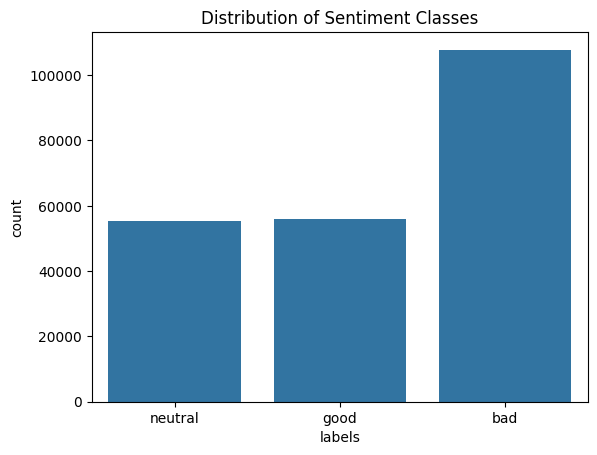

In [31]:
# Example EDA: Sentiment distribution
sns.countplot(x='labels', data=df)
plt.title('Distribution of Sentiment Classes')
plt.show()

# there is a lot of \n symbols and hashtages, links, mentions that need to be removed

## Preprocessing

social media text is messy so we will clean it
- Cleaning URLs, hashtags, and mentions, \n string, extra spaces, numbers, emojis, non-alphabet characters, making words lowercase
- expand contractions
- Tokenizing and removing stop words.
- Vectorizing text data for the SVM model.

Getting a random sample of the data so it does not take long to train the models

Also splitting data into training and test data

In [ ]:
# preprocessing
# extract the tweets input feature and the labels output feature (good, bad, neutral)
tweets = df['tweets']
tweets = np.array(tweets)
labels = df['labels']
labels = np.array(labels)


# function to clean tweets of
# clean tweets of hashtags, mentions, links, emojis, literal '\n' and any other characters that are not in the alphabet
def clean_tweet(tweet):
    # Convert the tweet to lowercase
    cleaned_tweet = tweet.lower()

    # Expand contractions
    cleaned_tweet = contractions.fix(cleaned_tweet)

    # Remove literal '\n' string
    cleaned_tweet = cleaned_tweet.replace(r'\n', '')

    # Remove links
    cleaned_tweet = re.sub(r'http\S+|www\S+|https\S+', '', cleaned_tweet)

    # Remove mentions
    cleaned_tweet = re.sub(r'@\w+', '', cleaned_tweet)

    # Remove hashtags
    cleaned_tweet = re.sub(r'#\w+', '', cleaned_tweet)

    # Remove emojis
    cleaned_tweet = cleaned_tweet.encode('ascii', 'ignore').decode('ascii')

    # Remove punctuations
    cleaned_tweet = re.sub(r'[^\w\s]', '', cleaned_tweet)

    # remove non alphabet characters
    cleaned_tweet = re.sub(r'[^a-zA-Z\s]', '', cleaned_tweet)

    # Remove numbers
    cleaned_tweet = re.sub(r'\d+', '', cleaned_tweet)

    # Remove extra spaces
    cleaned_tweet = re.sub(r'\s+', ' ', cleaned_tweet).strip()

    return cleaned_tweet


# function to get random sample of a numpy array of input features and numpy array of output features
def get_random_sample(input_features, output_features, sample_size):
    # Shuffle the indices of the dataset
    num_samples = input_features.shape[0]
    shuffled_indices = np.random.permutation(num_samples)

    # select a random sample of indices
    random_sample_indices = shuffled_indices[:sample_size]

    # Extract the corresponding samples from both input and output arrays
    input_sample = input_features[random_sample_indices]
    output_sample = output_features[random_sample_indices]
    return input_sample, output_sample


# going through all tweets and cleaning them, and removing stop words
for x in range(0, len(tweets)):
    tweets[x] = clean_tweet(tweets[x])
    tweets[x] = remove_stopwords(tweets[x])

# changing output features (labels) to numbers: good=0, neutral=1, bad =2
Y = []
for label in labels:
    if label == "good":
        Y.append(0)
    elif label == "neutral":
        Y.append(1)
    else:
        Y.append(2)
# converting Y into numpy array
Y = np.array(Y)

# getting random sample of data because it is too big to train and test on my machine (getting 8% of data)
test_sample_size = floor((len(tweets) * 0.08))
random_input_sample, random_output_sample = get_random_sample(tweets, Y, test_sample_size)
print(f"random input sample: {random_input_sample} \n")
print(f"random output sample: {random_output_sample} \n")

# tokenization of the tweets, remove words/features that only show up once, and vectorization of the words
vectorizer = CountVectorizer(min_df=2)
X = vectorizer.fit_transform(random_input_sample)
Y = random_output_sample
# printing feature info
print("-" * 100)
print(f" number of input features: {X.shape[1]}")
print("-" * 1000)
print(f" rows: {X.shape[0]}")
print(f" columns: {X.shape[1]}")
print("length of output features", len(Y))

# splitting data into training and test data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

# ...

## Modeling (SVM)
First, we'll train a Support Vector Machine model using Scikit-Learn.

In [ ]:
# training svm model
clf = svm.SVC(decision_function_shape='ovo')
clf.fit(x_train, y_train)
y_prediction_training = clf.predict(x_train)
y_prediction_test = clf.predict(x_test)

## Modeling (NN)

Training a Neural Network model using tensorflow.

In [ ]:
x_train_array = x_train.toarray()
x_test_array = x_test.toarray()
y_train_category = tf.keras.utils.to_categorical(y_train)
y_test_category = tf.keras.utils.to_categorical(y_test)

# Defining the architecture of your neural network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(x_train_array, y_train_category, epochs=10, batch_size=32)

## Summary

Comparing performance of both models using metrics such as accuracy, precision, recall, and F1 score. And discussing how they can be improved.

In [ ]:
print("\n------------------ Evaluation metrics of NN model from tensorflow ------------------")
# Evaluate the model on training data
train_loss, train_accuracy = model.evaluate(x_train_array, y_train_category)
# predict on train data
y_pred = model.predict(x_train_array)
y_pred_classes = tf.argmax(y_pred, axis=1)
# Calculate precision, recall, and F1 scores
precision, recall, f1, _ = precision_recall_fscore_support(y_train, y_pred_classes, average=None)
print("For training data: ")
print(f'Training Loss: {train_loss}')
print(f'Training Accuracy: {train_accuracy}')
for i in range(len(precision)):
    print(f'Class {i}: Precision={precision[i]}, Recall={recall[i]}, F1 Score={f1[i]}')
print("\n")

# Predict on test data
y_pred = model.predict(x_test_array)
y_pred_classes = tf.argmax(y_pred, axis=1)
# Calculate precision, recall, and F1 scores
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_classes, average=None)
print("For test data: ")
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(x_test_array, y_test_category)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')
# Print precision, recall, and F1 scores for each class
for i in range(len(precision)):
    print(f'Class {i}: Precision={precision[i]}, Recall={recall[i]}, F1 Score={f1[i]}')
print("----------------------------------------------------------------------------------\n")


print("\n------------------ Evaluation metrics of SVM model from sklearn ------------------")
# the accuracy score for the training and test data
print(f"Accuracy score for the training data: {accuracy_score(y_train, y_prediction_training)}\n")
print(f"Accuracy score for the test data: {accuracy_score(y_test, y_prediction_test)}\n")

# the recall scores for the training and test data
training_recall_scores = recall_score(y_train, y_prediction_training, average=None)
test_recall_scores = recall_score(y_test, y_prediction_test, average=None)
print(f"Recall scores for the training data: {training_recall_scores}: ")
print(f"recall training score for good label: {training_recall_scores[0]}")
print(f"recall training score for neutral label: {training_recall_scores[1]}")
print(f"recall training score for bad label: {training_recall_scores[2]}")
print("\n")
print(f"Recall scores for the test data: {test_recall_scores}: ")
print(f"recall test score for good label: {test_recall_scores[0]}")
print(f"recall test score for neutral label: {test_recall_scores[1]}")
print(f"recall test score for bad label: {test_recall_scores[2]}\n")

# the f1 score for the training and test data
training_f1_scores = f1_score(y_train, y_prediction_training, average=None)
test_f1_scores = f1_score(y_test, y_prediction_test, average=None)
print(f"f1 scores for the training data: {training_f1_scores}: ")
print(f"f1 training score for good label: {training_f1_scores[0]}")
print(f"f1 training score for neutral label: {training_f1_scores[1]}")
print(f"f1 training score for bad label: {training_f1_scores[2]}")
print("\n")
print(f"f1 scores for the test data: {test_f1_scores}: ")
print(f"f1 test score for good label: {test_f1_scores[0]}")
print(f"f1 test score for neutral label: {test_f1_scores[1]}")
print(f"f1 test score for bad label: {test_f1_scores[2]}")
print("\n")

# the precision score for the training and test data
training_precision_scores = precision_score(y_train, y_prediction_training, average=None)
test_precision_scores = precision_score(y_test, y_prediction_test, average=None)
print(f"Precision scores for the training data: {training_precision_scores}: ")
print(f"Precision training score for good label: {training_precision_scores[0]}")
print(f"Precision training score for neutral label: {training_precision_scores[1]}")
print(f"Precision training score for bad label: {training_precision_scores[2]}")
print("\n")
print(f"Precision scores for the test data: {test_precision_scores}: ")
print(f"Precision test score for good label: {test_precision_scores[0]}")
print(f"Precision test score for neutral label: {test_precision_scores[1]}")
print(f"Precision test score for bad label: {test_precision_scores[2]}")
print("----------------------------------------------------------------------------------\n")

#When it comes to accuracy the NN model is slightly better when looking at the test data 77% vs 75%.
# But it is still around the same accuracy for the test data. This means both the models perform the same when it comes to accuracy.
# For the training data both models do very well when it comes to accuracy over 90% and are significantly better than on the test data.
# This shows that the model is being overfitted as there is a significant drop-off in performance (90-70) from training accuracy to test accuracy.
# This overfitting is also shown in the recall scores, f1 scores, and precision score for the most part when comparing the training and test results.
# But there is an exception in the SVM model, for the recall training score for the bad label 99% vs 93% for the test data is not bad at all.
# This means the SVM model did a good job identifying class 2 which were the bad tweets. But it does not do as well for the good and neutral classes 74% and 40%. It does a bad job at identifying neutral tweets.
#This is also shown by the f1 and precision scores.
# For the NN model there was also an exception or at least when it came to the bad tweets it had the best performance when looking at precision, recall, and the f1 Score for the test data.
# Overall, the NN model is slightly better than the SVM model.
# Both the models could be improved by reducing the input features. It does not need to be that complex, there are probably a lot of words that do not have a ton of meaning for the model and because it overfits the training data for both models.
#They would also be better by using the entire dataset instead of a random sample, but training the model would take much longer in that case. I have waited a very long time and done it and get 85% accuracy with still a bit of overfitting.



## Conclusion

In this challenge, you've explored the application of SVM and Neural Networks to sentiment analysis on tweets about ChatGPT. Through EDA, preprocessing, and modeling, you've gained insights into the data and the performance of different types of models.

We encourage you to continue experimenting with different models, preprocessing techniques, and even dataset compositions to further your understanding of NLP and sentiment analysis.

